<a href="https://colab.research.google.com/github/Vakhranev/MDB/blob/main/Boxplots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 37.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=cef839adab39937e3bb66e1e0913b7797d56212a85eb8d346fecec2e44f71927
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


<ipython-input-23-0d145b3ba6e2>:129: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 0].set_xticklabels(['A1', 'A2', 'B1', 'B2'])
<ipython-input-23-0d145b3ba6e2>:135: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0, 1].set_xticklabels(['A1', 'A2', 'B1', 'B2'])
<ipython-input-23-0d145b3ba6e2>:141: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 0].set_xticklabels(['A1', 'A2', 'B1', 'B2'])
<ipython-input-23-0d145b3ba6e2>:147: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1, 1].set_xticklabels(['A1', 'A2', 'B1', 'B2'])


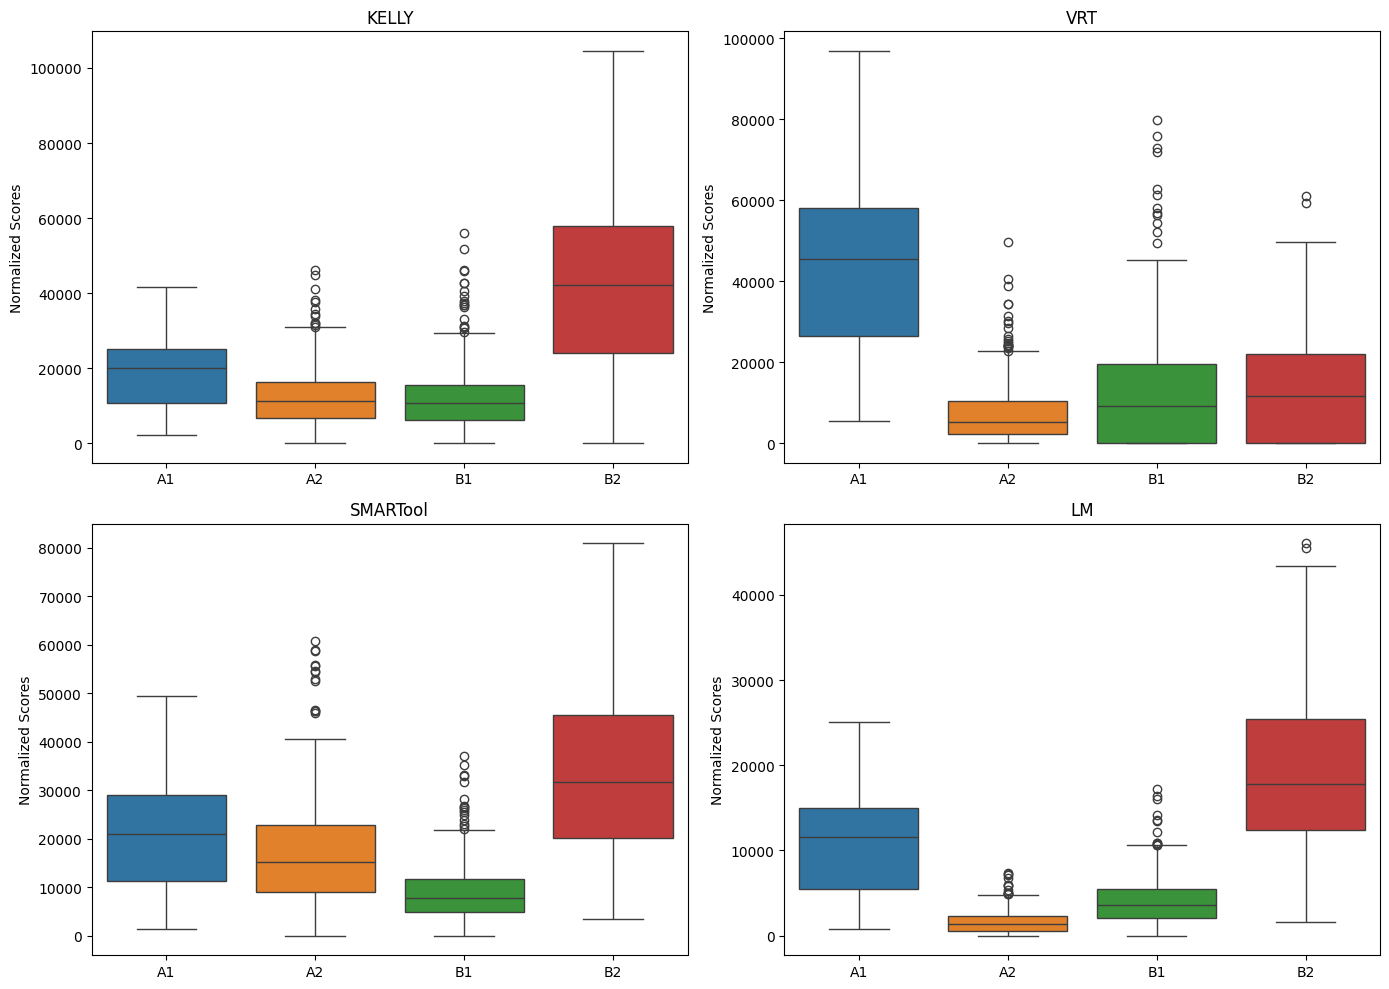

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import string
import re
import pymorphy2

# Создаем экземпляр морфологического анализатора pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()

# Функция для лемматизации текста
def lemmatize_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Удаление тегов типа <tag>
    text = text.replace('[unclear]', '')  # Удаление [unclear]
    words = re.findall(r'\b\w+\b', text)
    lemmas = [morph_analyzer.parse(word.lower())[0].normal_form for word in words if word.strip()]
    return lemmas

# Функция для обработки папки с текстами студентов
def process_folder(folder_path):
    unique_lemmas_by_level = {}
    for file_path in glob.glob(folder_path + "/*.txt"):
        with open(file_path, "r", encoding='utf-8') as file:
            text = file.read()
            lemmas = lemmatize_text(text)
            unique_lemmas = set(lemmas)
            unique_lemmas_by_level[file_path] = unique_lemmas
    return unique_lemmas_by_level

# Путь к папке с работами студентов
students_path = 'Students_texts'

# Загрузка данных KELLY
df_kelly = pd.read_csv('ru_m3.csv', sep=';')
df_kelly.index = np.arange(1, len(df_kelly) + 1)
kelly_levels = {
    'A1': df_kelly.query('CEFR == "a1" | CEFR == "A1"')['Lemma'].str.lower().tolist(),
    'A2': df_kelly.query('CEFR == "a2" | CEFR == "A2"')['Lemma'].str.lower().tolist(),
    'B1': df_kelly.query('CEFR == "b1" | CEFR == "B1"')['Lemma'].str.lower().tolist(),
    'B2': df_kelly.query('CEFR == "b2" | CEFR == "B2"')['Lemma'].str.lower().tolist()
}

# Загрузка данных VRT
df_vrt = pd.read_csv('lemmas_levels.csv', sep=',')
df_vrt.index = np.arange(1, len(df_vrt) + 1)
vrt_levels = {
    'A1': df_vrt.query('level == "1E"')['lemma'].str.strip('\'').tolist(),
    'A2': df_vrt.query('level == "2I"')['lemma'].str.strip('\'').tolist(),
    'B1': df_vrt.query('level == "3AU"')['lemma'].str.strip('\'').tolist(),
    'B2': df_vrt.query('level == "4S"')['lemma'].str.strip('\'').tolist()
}

# Загрузка данных SMARTool
df_a1 = pd.read_csv('A1.csv', sep=';')
df_a2 = pd.read_csv('A2.csv', sep=';')
df_b1 = pd.read_csv('B1.csv', sep=';')
df_b2 = pd.read_csv('B2.csv', sep=';')
smartool_levels = {
    'A1': df_a1['Lemma'].str.lower().tolist(),
    'A2': df_a2['Unnamed: 0'].str.lower().tolist(),
    'B1': df_b1['Lemma'].str.lower().tolist(),
    'B2': df_b2['Lemma'].str.lower().tolist()
}

# Загрузка данных LM
lm_files = ['new_vocab_a1.csv', 'new_vocab_a2.csv', 'new_vocab_b1.csv', 'new_vocab_b2.csv']
lm_data = {}
for i, file in enumerate(lm_files):
    df_lm = pd.read_csv(file, sep=';')
    df_lm.index = np.arange(1, len(df_lm) + 1)
    df_lm = df_lm[df_lm['а'].str.len() > 1]
    level = ['A1', 'A2', 'B1', 'B2'][i]
    lm_data[level] = df_lm['а'].str.lower().tolist()

lm_levels = {
    'A1': lm_data['A1'],
    'A2': list(set(lm_data['A2']) - set(lm_data['A1'])),
    'B1': list(set(lm_data['B1']) - set(lm_data['A2'])),
    'B2': list(set(lm_data['B2']) - set(lm_data['B1']))
}

# Обрабатываем папки с работами студентов
student_work = {}
folders = ['A1', 'A2', 'B1', 'B2']
for folder in folders:
    folder_path = os.path.join(students_path, folder)
    student_work[folder] = process_folder(folder_path)

# Функция для подсчета суммы баллов для каждого файла
def calculate_sum_scores(student_work, levels_dict):
    sum_scores = {level: [] for level in student_work.keys()}
    for level, works in student_work.items():
        for file, words in works.items():
            score = sum(len(levels_dict[level]) - levels_dict[level].index(word) for word in words if word in levels_dict[level])
            sum_scores[level].append(score)
    return sum_scores

# Подсчитываем суммы баллов для каждого словаря и уровня
sum_scores_kelly = calculate_sum_scores(student_work, kelly_levels)
sum_scores_vrt = calculate_sum_scores(student_work, vrt_levels)
sum_scores_smartool = calculate_sum_scores(student_work, smartool_levels)
sum_scores_lm = calculate_sum_scores(student_work, lm_levels)

# Функция для нормализации сумм баллов в диапазоне от 0 до 1
def normalize_scores(scores):
    normalized_scores = {}
    for level, level_scores in scores.items():
        min_score = min(level_scores)
        max_score = max(level_scores)
        normalized_level_scores = [(score - min_score) / (max_score - min_score) for score in level_scores]
        normalized_scores[level] = normalized_level_scores
    return normalized_scores

# Нормализуем суммы баллов для каждого словаря
normalized_kelly = normalize_scores(sum_scores_kelly)
normalized_vrt = normalize_scores(sum_scores_vrt)
normalized_smartool = normalize_scores(sum_scores_smartool)
normalized_lm = normalize_scores(sum_scores_lm)

# Строим графики с ящиками с усами для нормализованных сумм баллов
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# График для KELLY
sns.boxplot(data=list(sum_scores_kelly.values()), ax=axs[0, 0])
axs[0, 0].set_title('KELLY')
axs[0, 0].set_xticklabels(['A1', 'A2', 'B1', 'B2'])
axs[0, 0].set_ylabel('Normalized Scores')

# График для VRT
sns.boxplot(data=list(sum_scores_vrt.values()), ax=axs[0, 1])
axs[0, 1].set_title('VRT')
axs[0, 1].set_xticklabels(['A1', 'A2', 'B1', 'B2'])
axs[0, 1].set_ylabel('Normalized Scores')

# График для SMARTool
sns.boxplot(data=list(sum_scores_smartool.values()), ax=axs[1, 0])
axs[1, 0].set_title('SMARTool')
axs[1, 0].set_xticklabels(['A1', 'A2', 'B1', 'B2'])
axs[1, 0].set_ylabel('Normalized Scores')

# График для LM
sns.boxplot(data=list(sum_scores_lm.values()), ax=axs[1, 1])
axs[1, 1].set_title('LM')
axs[1, 1].set_xticklabels(['A1', 'A2', 'B1', 'B2'])
axs[1, 1].set_ylabel('Normalized Scores')

plt.tight_layout()
plt.show()